In [103]:
from tkinter import *
from tkinter import ttk, filedialog
from tkinter.filedialog import askopenfilename
import csv
from pathlib import Path
import pymongo
import numpy as np
# Use sentinel for missing values
from numpy import nan as NA
import pandas as pd
# For showing plots in tkinter
import matplotlib.pyplot as plt
from matplotlib.figure import Figure 
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg,  
NavigationToolbar2Tk) 
import seaborn as sns
import tkinter.constants as Tkconstants

# connect to mongodb
client = pymongo.MongoClient("mongodb://localhost:27017")
# create db
db_formative = client["summative"]
# create collection
collection_vendors = db_formative["test-167"]

In [104]:
fileButtons = ["inspections", "inventory", "violations"]
fileRoutes = {fileButtons[0]:"", fileButtons[1]:"", fileButtons[2]:""}

In [105]:
class Parser(object):
    def __init__(self, collection, csvFile):
        self.collection = collection
        self.csvFile = csvFile
        self.inspectionsDF = None
        self.inventoryDF = None
        self.violationsDF = None
        
    def parseData(self):
        # Read CSV files and convert to Pandas DataFrames
        self.inspectionsDF = pd.read_csv(self.csvFile['inspections'], usecols=['ACTIVITY DATE', 'FACILITY ID', 'FACILITY NAME', 'PROGRAM STATUS', 'PE DESCRIPTION', 'FACILITY ZIP', 'SERIAL NUMBER', 'SCORE'])
        self.inventoryDF = pd.read_csv(self.csvFile['inventory'])
        self.violationsDF = pd.read_csv(self.csvFile['violations'], usecols=['SERIAL NUMBER', 'VIOLATION CODE'])
        
        return self.inspectionsDF, self.inventoryDF, self.violationsDF
                

In [106]:
class DataCleaner(object):
    def __init__(self, inspections, inventory, violations):
        self.inspectionsDF = inspections
        self.inventoryDF = inventory
        self.violationsDF = violations
        
    def clean(self):
        print('cleaning')
        self.cleanInspections()
        return self.inspectionsDF, self.inventoryDF, self.violationsDF
        
    def cleanInspections(self):
        # Extract info from PE DESC column and create new col for SEATING DETAILS
        self.inspectionsDF['SEATING DETAILS'] = self.inspectionsDF['PE DESCRIPTION'].str.extract(r"\(([\S ]+)\)")
        print(f'seating deats \n{self.inspectionsDF["SEATING DETAILS"]}')
        print(f'pe desc \n{self.inspectionsDF["PE DESCRIPTION"]}')
        # Extract first part of Zip Code (e.g. '90001-1234', becomes '90001')
        self.inspectionsDF['FACILITY ZIP'] = self.inspectionsDF['FACILITY ZIP'].str.extract(r"([0-9]+)") 
        # Add '_id' for MongoDB      
        self.inspectionsDF['_id'] = 'INS_' + self.inspectionsDF['SERIAL NUMBER']
        # Add '_id' for MongoDB
        self.violationsDF['_id'] = 'VIO_' + self.violationsDF.index.map(str) + '_' + self.violationsDF['SERIAL NUMBER']


In [107]:
class DataLoader(object):
    def __init__(self, inspections, inventory, violations):
        self.inspectionsDF = inspections
        self.inventoryDF = inventory
        self.violationsDF = violations
        
    def loadToMongo(self):
        # use to_dict to format correctly for MongoDB
        inspectionsDict = self.inspectionsDF.to_dict(orient='records')
        inventoryDict = self.inventoryDF.to_dict(orient='records')
        violationsDict = self.violationsDF.to_dict(orient='records')
        # Insert into Mongo
        collection_vendors.insert_many(inspectionsDict)
#         collection_vendors.insert_many(inventoryDict)
        collection_vendors.insert_many(violationsDict)
        # Embed violations
#         self.formatViolations()
        # Test db
        test = collection_vendors.find({'_id':{'$regex':'INS_'}})
        for t in test:
            print(f'testing inspections: \n{t}')
            break
        print('inserted into Mongo')
        
#     def formatViolations(self):
#         # Use aggregation to create list of violations per serial number 
#         violationsDocs = collection_vendors.aggregate([
#             {'$match': {'_id': {'$regex': 'VIO_'}}},
#             {'$group': {'_id': '$SERIAL NUMBER','VIOLATIONS': {'$push': '$VIOLATION CODE'}}},
#         ])
#         # Update the inspections with the new violations lists
#         for v in violationsDocs:
#             collection_vendors.update_one({'_id':'INS_'+v['_id']}, {'$set': {'VIOLATIONS': v['VIOLATIONS']}})
        
           

In [108]:
class ButtonUpload(object):
    def __init__(self, fileButtons, fileLabels, counter, mainframe):
        self.fileButtons = fileButtons
        self.fileLabels = fileLabels
        self.counter = counter
        self.mainframe = mainframe
        self.filePath = ''
        self.uploadLabel = StringVar()

    def browseFile(self):
        self.filePath = askopenfilename(filetypes=[("CSV files", ".csv")])
        fileName = Path(self.filePath)
        self.uploadLabel.set(fileName.name)
        print(self.filePath)
        self.setFileRoutes()
    
    def setFileRoutes(self):
        fileRoutes[self.fileButtons] = self.filePath
        print(fileRoutes)
        
    def createButton(self):
        ttk.Label(self.mainframe, text=f"Upload data: {self.fileButtons}", anchor="w").grid(row=self.counter+1, column=0, sticky="w")
        Button(self.mainframe, text="Upload file", command=self.browseFile).grid(row=self.counter+1, column=1, sticky="w")
        ttk.Label(self.mainframe, textvariable=self.uploadLabel).grid(row=self.counter+1, column=2, sticky="w") 
        

In [109]:
class AveragesCalculator(object):
    def __init__(self, year, category):
        self.year = year
        self.category = category
        
    def zipScores(self):
        print(f'Calculating stats for: \n- Year = {self.year} \n- Category = {self.category}')
        # Find inspection documents - look in ispections (INS_) with year
        resultsInspections = collection_vendors.find({'_id':{'$regex':'INS_'},'ACTIVITY DATE':{'$regex':self.year}, 'PROGRAM STATUS': 'ACTIVE'})

        # Create dict of facility zips with lists of their scores
        zipScoresDict = {}  
        for r in resultsInspections:
            key = r[self.category]
            if key in zipScoresDict:
                zipScoresDict[r[self.category]].append(r['SCORE'])
            else:
                zipScoresDict[key] = [r['SCORE']]
        return self.calcZipStats(zipScoresDict)


    def calcZipStats(self, zipScoresDict):
        zipScoresMean = {}
        zipScoresMean = {self.category:[],'mean':[],'median':[],'mode':[]}
        for x in zipScoresDict:
            # Create Series to calc mean, mode, median
            tempSeries = pd.Series(zipScoresDict[x])
            mean = tempSeries.mean()
            mode = tempSeries.mode().tolist()
            median = tempSeries.median()

            # mean, mode, median as columns
            zipScoresMean[self.category].append(x)
            zipScoresMean['mean'].append(mean)
            zipScoresMean['median'].append(median)
            zipScoresMean['mode'].append(mode)

        # Create DataFrame
        zipScoresDF = pd.DataFrame(zipScoresMean)
        # sort by ascending cat - easier to find for user (esp. zip)
        zipScoresDF.sort_values(by=[self.category],inplace=True)
        # set cat as index
        zipScores_noIndex = zipScoresDF.set_index(self.category)
        
        return zipScores_noIndex
 

In [110]:
class UserInterface(object):
    def __init__(self, title):
        self.title = title
        self.mainframe = None
        self.window = Tk()
        self.window.title(self.title)
        self.window.geometry("1200x800")
        self.window.columnconfigure(0, weight=1)
        self.window.rowconfigure(0, weight=1)
        self.calcCategory = StringVar()
        self.calcYear = StringVar()
        self.dataDict = None
        self.violationsDF = None
        self.window.rowconfigure( 0, weight=1 )     # You need to add this. 
        self.window.columnconfigure( 0, weight=1 )  # You need to add this.
        self.cleanedData = None
        
    def createWindow(self):
        self.createInitialFrame()
        self.window.mainloop()
        
    def createInitialFrame(self):
         # variables
        labelTextOne = StringVar()
        labelTextTwo = StringVar()
        labelTextThree = StringVar()
        fileLabels = [labelTextOne, labelTextTwo, labelTextThree]
        # Config layout
        self.mainframe = ttk.Frame(self.window, padding="16 16 16 16")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        self.mainframe.grid_rowconfigure(4, weight=1)
        self.mainframe.grid_columnconfigure(2, weight=1)
        heading = ttk.Label(self.mainframe, text="Load your dataset", anchor="w").grid(row=0, sticky="nw")
        # Create buttons for file uploads
        for i in range(0, len(fileButtons)): 
            newButton = ButtonUpload(fileButtons[i], fileLabels[i], i, self.mainframe)
            newButton.createButton()
        # Buttons for Cancel and Clean & Save
        footer = ttk.Frame(self.window, padding="16 0 0 0").grid(row=5, column=1)
        cancelButton = Button(self.mainframe, text="Cancel & exit", bg="red").grid(row=4, column=0, sticky="sw")
        saveButton = Button(self.mainframe, text="Load & clean dataset", command=self.handleSave).grid(row=4, column=2,sticky="se")
        
    def handleSave(self):
        # parse data
        parser = Parser(collection_vendors, fileRoutes)
        parsedData = parser.parseData()
        self.violationsDF = parsedData[2]
        # Clean data - pass data returned from parser
        cleaner = DataCleaner(*parsedData)
        self.cleanedData = cleaner.clean()
        print('done handleSave')
        self.uploadFrame()
        
    def uploadFrame(self):
        self.mainframe.destroy()
        self.mainframe = ttk.Frame(self.window, padding="16 16 16 16")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        heading = ttk.Label(self.mainframe, text="The data has been prepared and cleaned.", anchor="w").grid(row=0, sticky="nw")
        subheading = ttk.Label(self.mainframe, text="Please press continue to load data to MongoDB and proceed.", anchor="w").grid(row=1, sticky="nw")
        saveButton = Button(self.mainframe, text="Continue", command=self.handleLoadToDB).grid(row=2 ,sticky="nw")
        print('done uploadFrame')
        
    def handleLoadToDB(self):
        # Insert to MongoDB - pass data returned from cleaner
        loader = DataLoader(*self.cleanedData)
        loader.loadToMongo()
        print('done handleLoadToDB')
        self.createNotebook()
        
    def createNotebook(self):
        print('Creating Notebook (Tabs)')
        self.mainframe.destroy()
        self.mainframe = ttk.Notebook(self.window)
        f1 = ttk.Frame(self.mainframe)  
        f2 = ttk.Frame(self.mainframe)  
        f3 = ttk.Frame(self.mainframe) 
        self.mainframe.add(f1, text='Averages')
        self.mainframe.add(f2, text='Violations per Establishment')
        self.mainframe.add(f3, text='Correlations')
        # ====== Widget for tab 1
        heading_one = ttk.Label(f1, text="Mean, Mode and Median", anchor="w").grid(row=0, sticky="nw")
        # Radio - Type
        radioHeadingOne = ttk.Label(f1, text="Calculate by seating type or zip codes:", anchor="w").grid(row=0, sticky="nw")
        Radiobutton(f1, text="Vendor seating type", padx = 20, variable=self.calcCategory, value='SEATING DETAILS').grid(row=1, column=0, sticky='w')
        Radiobutton(f1, text="Zip Code", padx = 20, variable=self.calcCategory, value='FACILITY ZIP').grid(row=2, column=0, sticky='w')
        # Radio - Years
        radioHeadingTwo = ttk.Label(f1, text="Select Year", anchor="w").grid(row=3, sticky="nw")
        yearsArr = ['2016', '2017', '2018', '2019']
        for i in range(len(yearsArr)):
            Radiobutton(f1, text=yearsArr[i], padx = 20, variable=self.calcYear, value=yearsArr[i]).grid(row=i+4, column=0, sticky='w')
        # Calc button
        calcButton = Button(f1, text="Calculate", command=self.calcAverages).grid(row=8, column=0, sticky="sw")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        
        # ====== Widget for tab 2
        heading_two = ttk.Label(f2, text="Number of establishments that have committed each type of violation.", anchor="w").grid(row=0, sticky="nw")
        violationsButton = Button(f2, text="Show violations plot", command=lambda:self.createViolationsPlot(f2)).grid(row=1, column=0, sticky="sw")
    
        
        # ====== Widget for tab 3
        heading_two = ttk.Label(f3, text="Correlation between the number of violations commited per vendor and their zip code", anchor="w").grid(row=0, sticky="nw")
        correlationsButton = Button(f3, text="Show correlations plot", command=self.createCorrelationsPlot).grid(row=1, column=0, sticky="sw")
        
    def createViolationsPlot(self, f2):
        newCol2 = collection_vendors.aggregate([
            {'$group': {'_id': '$SERIAL NUMBER', 'FACILITY NAME': {'$addToSet': '$FACILITY NAME'}, 'VIOLATIONS': {'$addToSet': '$VIOLATION CODE'}}}
        ])

        # Find out what violations were committed by each facility
        # Use a set() to get unique entries 
        # (violations may be committed multiple times by same facility but I only want to count that facility once)
        facVios = {}
        for i in newCol2:
            try:
                if i['FACILITY NAME'][0] in facVios:
                    facVios[i['FACILITY NAME'][0]].update(i['VIOLATIONS'])
                else:
                    facVios[i['FACILITY NAME'][0]] = set()
                    facVios[i['FACILITY NAME'][0]].update(i['VIOLATIONS'])
            except:
                print('error')

        uniqueVCodes = {}
        for f in facVios:
            for i in facVios[f]:
                if i in uniqueVCodes:
                    uniqueVCodes[i] = uniqueVCodes[i] + 1
                else:
                    uniqueVCodes[i] = 1  

        # Convert data to DataFrame and sort the data descending by value
        data = {'keys':list(uniqueVCodes.keys()), 'values':list(uniqueVCodes.values())}
        uniqueVCodesDF = pd.DataFrame(data)
        uniqueVCodesDF.sort_values(by='values',ascending=False,inplace=True)
        print(uniqueVCodesDF)
        # Display violations vs no. of establishments
        vioKeys = uniqueVCodesDF['keys']
        vioVals = uniqueVCodesDF['values']
        # Create 4 subplots using slices of the keys & values lists
        fig,a =  plt.subplots(2,2)
        a[0][0].bar(vioKeys[:round(len(vioKeys)*0.25)], vioVals[:round(len(vioKeys)*0.25)])
        a[0][1].bar(vioKeys[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)], vioVals[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)])
        a[1][0].bar(vioKeys[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)], vioVals[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)])
        a[1][1].bar(vioKeys[round(len(vioKeys)*0.75):], vioVals[round(len(vioKeys)*0.75):])
        # Tidy plot - rotate labels & apply layout
        a[0][0].tick_params(axis='x',labelrotation=45)
        a[0][1].tick_params(axis='x',labelrotation=45)
        a[1][0].tick_params(axis='x',labelrotation=45)
        a[1][1].tick_params(axis='x',labelrotation=45)
        plt.tight_layout()
        # Show in console as well as window
        plt.show()
        # creating the Tkinter canvas containing the Matplotlib figure 
        canvas = FigureCanvasTkAgg(fig, master = f2)   
        canvas.draw() 
        # grid the canvas on the Tkinter window 
        canvas.get_tk_widget().place(relheight=1, relwidth=1) 
        
    def createCorrelationsPlot(self):    
        # find the violations with fac name and zip
        newCol = collection_vendors.aggregate([
            {'$group': {'_id': '$SERIAL NUMBER', 'FACILITY NAME': {'$addToSet':'$FACILITY NAME'},'ZIP': {'$addToSet':'$FACILITY ZIP'}, 'VIOLATIONS': {'$addToSet': '$VIOLATION CODE'}}}
        ])
        # Create dict with zip code: [violations no. per facility]
        vioDict = {}
        for n in newCol:
            try:
                zipCode = n['ZIP'][0] + ' -'
            except:
                print("oooo Unexpected error:", sys.exc_info()[0])
                continue
            if zipCode in vioDict:
                vioDict[zipCode].append(len(n['VIOLATIONS']))
            else:
                vioDict[zipCode] = [len(n['VIOLATIONS'])]
        # Calc mean for violation no.
        for v in vioDict:
            tempSeries = pd.Series(vioDict[v])
            mean = tempSeries.mean()
            vioDict[v] = mean
                
        #  Create DataFrame - sorted by zip to make visualisations easier to understand
        data = {
            'quantity': list(vioDict.values()),
            'zip': list(vioDict.keys())
        }
        insViosDF = pd.DataFrame(data)
        insViosDF.sort_values(by=['quantity'],inplace=True)
        print(insViosDF)
        
        # New window
        window = Tk()
        window.title(self.title)
        window.geometry("1200x800")
        window.columnconfigure(0, weight=1)
        window.rowconfigure(0, weight=1)
        
        # Scroll Y
        frame=Frame(window)
        frame.grid(row=0,column=0)
        frame.columnconfigure(0, weight=1)
        frame.rowconfigure(0, weight=1)
        canvas = Canvas(frame)
#         canvas.grid(row=0, column=0, sticky=Tkconstants.NSEW)
        canvas.grid(row=0, column=0)
        yScrollbar = Scrollbar(frame)
        yScrollbar.grid(row=0, column=1, sticky=Tkconstants.NS)
        canvas.config(yscrollcommand=yScrollbar.set)
        yScrollbar.config(command=canvas.yview)
        
        
        # Creating the figure and Seaborn plot
        figure = Figure(figsize=(8, 40))
        ax = figure.subplots()
        sns.barplot(x="quantity", y="zip", data=insViosDF, label="Total", color="b", ax=ax, ci=None)
        
        # create the Tkinter canvas 
        canvasInner = FigureCanvasTkAgg(figure, master = canvas)   
        canvasInner.draw() 

        # place the canvas on the Tkinter window 
        mplCanvas = canvasInner.get_tk_widget()
        
        cwid = canvas.create_window(0, 0, window=mplCanvas, anchor=Tkconstants.NW)
        canvas.config(scrollregion=canvas.bbox(Tkconstants.ALL),width=800,height=800)
        
#         window.mainloop()
    
    def calcAverages(self):
        calcCatVal = self.calcCategory.get()
        calcYearVal = self.calcYear.get()
        calcAv = AveragesCalculator(calcYearVal, calcCatVal)
        avResults = calcAv.zipScores()
        self.averagesResultsFrame(avResults, calcYearVal, calcCatVal)
        
    def averagesResultsFrame(self, resultsAv, calcYearVal, calcCatVal):
        avResultsWindow = Tk()
        avResultsWindow.title(f'Averages Results for {calcCatVal} in {calcYearVal}')
        avResultsWindow.geometry("600x400")
        mainframe = ttk.Frame(avResultsWindow, padding="16 16 16 16")
        mainframe.place(relheight=1, relwidth=1)

        tree = ttk.Treeview(mainframe)
        tree.place(relheight=1, relwidth=1)
        treescrolly = Scrollbar(mainframe, orient='vertical', command=tree.yview)
        treescrollx = Scrollbar(mainframe, orient='horizontal', command=tree.xview)
        tree.configure(xscrollcommand=treescrollx.set, yscrollcommand=treescrolly.set)
        treescrolly.pack(side='right', fill='y')
        treescrollx.pack(side='bottom', fill='x')

        tree["columns"]=("one","two","three")
        tree.column("#0", width=75, minwidth=75)
        tree.column("one", width=75, minwidth=75)
        tree.column("two", width=75, minwidth=75)
        tree.column("three", width=75, minwidth=75)

        tree.heading("#0",text="Category")
        tree.heading("one", text="Mean")
        tree.heading("two", text="Median")
        tree.heading("three", text="Mode")

        for index, row in resultsAv.iterrows(): 
            tree.insert('','end', text=index, values=[row['mean'],row['median'],row['mode']])
        print(f'This is resultsAv: \n{resultsAv}')
 

/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections.csv', 'inventory': '', 'violations': ''}
/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections.csv', 'inventory': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory.csv', 'violations': ''}
/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/violations.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections.csv', 'inventory': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory.csv', '

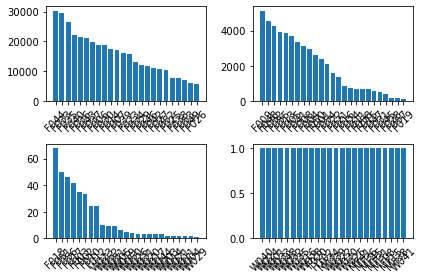

In [111]:
ui = UserInterface('summative')
ui.createWindow()

In [57]:
ui = UserInterface('summative')
ui.createCorrelationsPlot()


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'_id': 'F037', 'FACILITIES': ['DA4NVN5CM', 'DABCRFIUD', 'DAHO1CGQI', 'DAJP6YJCF', 'DAADS8RVV', 'DAJRW7VQH', 'DAI0E58CI', 'DATQABVZT', 'DATW4SF0P', 'DAUQT5QT7', 'DAXYCEEXE', 'DAHSCDKKR', 'DAHPHGI2H', 'DAAJPPAYY', 'DACVNENEE', 'DAVTF4AKO', 'DAS3AE9RP', 'DA0JJT7E6', 'DASE0JLRJ', 'DA6MDGTQE', 'DA6Q2BEGM', 'DAV0QD0BB', 'DA9K7TGCG', 'DARBSKBMI', 'DAOXJJXTW', 'DATVF4YSY', 'DAMAFTQSI', 'DAL7ZI0I4', 'DAHKE6YQP', 'DAXUNV5SF', 'DALXK6KOH', 'DAHZVNNCJ', 'DA86JRE9P', 'DAC07R64G', 'DAT1LU9OO', 'DAI76CDLT', 'DAKU351JN', 'DAPLKMZY0', 'DAUBYBCD9', 'DAKJ6OQAL', 'DATQLOPTL', 'DAKQDIN5G', 'DAQUOBX70', 'DATXVVKNG', 'DAHKF23EJ', 'DAKCVLXFL', 'DAB0RVKBI', 'DAU5MZ4QA', 'DAZ2GDSQ3', 'DAMD8ARFT', 'DAQNBEK0M', 'DATTKV4D7', 'DA5N930MY', 'DABEFJKYV', 'DABFCRDUY', 'DAJ7B7S3E', 'DADVK10LZ', 'DAKC0VDUM', 'DAOPE5YHJ', 'DATCMMQRX', 'DACFMTP66', 'DAYZKQICF', 'DAIRHXE06', 'DABNT8UDP', 'DA2HNIJCD', 'DA6QSIFQF', 'DA0H6GUNQ', 'DA0HAFLUN', 'DADT1HVXH', 'DANCLGTUO', 'DADIHQYZG', 'DAEJ269LK', 'DAO0G44H7', 'DAJSBGAUF', 'DAKAZP

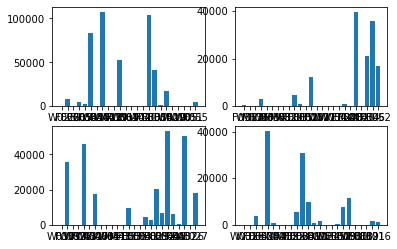

In [5]:
newCol = collection_vendors.aggregate([
    {'$match': {'_id': {'$regex':'VIO_'}}},
    {'$group': {'_id': '$VIOLATION CODE', 'FACILITIES': {'$addToSet': '$SERIAL NUMBER'}}}
])

vioDict = {}
for n in newCol:
    vioDict[n['_id']] = len(n['FACILITIES'])
    print(n)

# Display violations vs no. of establishments
vioKeys = list(vioDict.keys())
vioVals = list(vioDict.values())
# Create 4 subplots using slices of the keys & values lists
fig,a =  plt.subplots(2,2)
a[0][0].bar(vioKeys[:round(len(vioKeys)*0.25)], vioVals[:round(len(vioKeys)*0.25)])
a[0][1].bar(vioKeys[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)], vioVals[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)])
a[1][0].bar(vioKeys[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)], vioVals[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)])
a[1][1].bar(vioKeys[round(len(vioKeys)*0.75):], vioVals[round(len(vioKeys)*0.75):])
# Show in console as well as window
plt.show()

In [4]:
vioDict

{'F035': 83459,
 'W048': 1,
 'F044': 107177,
 'W022': 1,
 'W039': 1,
 'F005': 5031,
 'F054': 2713,
 'F020': 1,
 'W025': 2,
 'F026': 8305,
 'W051': 10,
 'F055': 5203,
 'F010': 24,
 'F058': 832,
 'F042': 17539,
 'W019': 5,
 'W014': 2,
 'W035': 1,
 'W040': 1,
 'F033': 104253,
 'F007': 41770,
 'W005': 6,
 'F036': 53114,
 'W004': 2,
 'F002': 35,
 'F025': 12453,
 'H102': 1,
 'MF34': 1,
 'W029': 1,
 'F013': 4812,
 'F015': 749,
 'MF31': 1,
 'MF08': 2,
 'F031': 646,
 'W023': 12,
 'MF36': 5,
 'F050': 2946,
 'F006': 35961,
 'F052': 17040,
 'MF41': 1,
 'F039': 35898,
 'F028': 192,
 'F014': 39522,
 'W030': 1,
 'F034': 21086,
 'W033': 1,
 'W050': 4,
 'W044': 3,
 'F024': 833,
 'W020': 3,
 'F017': 44,
 'W021': 3,
 'W017': 3,
 'W028': 1,
 'W001': 1,
 'MF38': 1,
 'F003': 35,
 'F053': 9716,
 'F056': 49,
 'F046': 17659,
 'W003': 2,
 'W041': 1,
 'F043': 45920,
 'W031': 3,
 'F037': 50706,
 'W026': 3,
 'F027': 18339,
 'W032': 1,
 'F048': 6147,
 'F045': 491,
 'F029': 20238,
 'F040': 53492,
 'F032': 6623,
 'F0

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
    keys  values
1   F044   30219
0   F033   29373
4   F035   26515
11  F040   22126
9   F036   21400
..   ...     ...
53  MF31       1
54  MF08       1
55  MF15       1
56  MF38       1
97  W041       1

[98 rows x 2 columns]


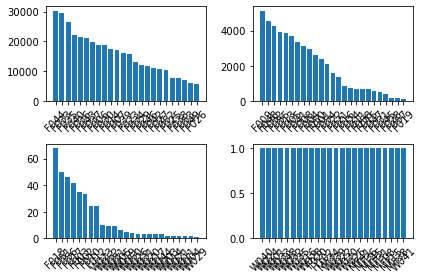

In [102]:
newCol2 = collection_vendors.aggregate([
    {'$group': {'_id': '$SERIAL NUMBER', 'FACILITY NAME': {'$addToSet': '$FACILITY NAME'}, 'VIOLATIONS': {'$addToSet': '$VIOLATION CODE'}}}
])

# Find out what violations were committed by each facility
# Use a set() to get unique entries 
# (violations may be committed multiple times by same facility but I only want to count that facility once)
facVios = {}
for i in newCol2:
#     print(i)
    try:
        if i['FACILITY NAME'][0] in facVios:
            facVios[i['FACILITY NAME'][0]].update(i['VIOLATIONS'])
        else:
            facVios[i['FACILITY NAME'][0]] = set()
            facVios[i['FACILITY NAME'][0]].update(i['VIOLATIONS'])
    except:
        print('error')
    
uniqueVCodes = {}
for f in facVios:
    for i in facVios[f]:
        if i in uniqueVCodes:
            uniqueVCodes[i] = uniqueVCodes[i] + 1
        else:
            uniqueVCodes[i] = 1  
            

data = {'keys':list(uniqueVCodes.keys()), 'values':list(uniqueVCodes.values())}
uniqueVCodesDF = pd.DataFrame(data)
uniqueVCodesDF.sort_values(by='values',ascending=False,inplace=True)
print(uniqueVCodesDF)
# Display violations vs no. of establishments
vioKeys = uniqueVCodesDF['keys']
vioVals = uniqueVCodesDF['values']
# Create 4 subplots using slices of the keys & values lists
fig,a =  plt.subplots(2,2)

a[0][0].bar(vioKeys[:round(len(vioKeys)*0.25)], vioVals[:round(len(vioKeys)*0.25)])
a[0][1].bar(vioKeys[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)], vioVals[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)])
a[1][0].bar(vioKeys[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)], vioVals[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)])
a[1][1].bar(vioKeys[round(len(vioKeys)*0.75):], vioVals[round(len(vioKeys)*0.75):])
# Show in console as well as window
a[0][0].tick_params(axis='x',labelrotation=45)
a[0][1].tick_params(axis='x',labelrotation=45)
a[1][0].tick_params(axis='x',labelrotation=45)
a[1][1].tick_params(axis='x',labelrotation=45)
plt.tight_layout()
plt.show()


In [93]:
x = {'f05':1, 'f04':2, 'f01':3}
df = pd.DataFrame(x)

ValueError: If using all scalar values, you must pass an index

In [97]:
y = sorted(x.values())

In [98]:
y

[1, 2, 3]

In [94]:
df = pd.DataFrame(y)

In [95]:
df

,0,1
0,f01,3
1,f04,2
2,f05,1
